In [ ]:
#NEW PLOT FOR COMPARISON OF VALIDATION - 2d using geodataframe
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
from hydra import initialize, compose
from preprocessing.utils import getArea,find_nearest_index,scaleLongitudes
import rioxarray 
import xarray

with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")


In [271]:
#PREP NFIS DATA
nfis_data = pd.read_csv('data/nfis_agb.csv')
nfis_data['agb'] = nfis_data['agb'] / 10 #ha to m2
nfis_data['area'] = nfis_data.apply(lambda x: getArea(x['lat'],x['lon']),axis=1)
# nfis_data['lat'] = round(nfis_data['lat'],6)
nfis_data['agb'] = nfis_data['agb'] * nfis_data['area'] / 1e9 #to megatonnes
nfis_data_boxes = get_box(nfis_data)
nfis_gdf = gpd.GeoDataFrame(nfis_data['agb'], geometry=nfis_data_boxes)

In [ ]:
#PREP WWF DATA
soil_df = rioxarray.open_rasterio('/Users/gclyne/thesis/McMaster_WWFCanada_soil_carbon1m_250m/McMaster_WWFCanada_soil_carbon1m_250m_kg-m2_version1.0.tif')
ref_df = xarray.open_dataset('/Users/gclyne/thesis/data/cesm/cSoilAbove1m_Emon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc')
ref_df = ref_df.rio.set_crs('epsg:4326')
soil_df = soil_df.rio.reproject_match(ref_df)
soil_df = soil_df.rename({'x':'lon','y':'lat'})
canada_mf_shapefile = gpd.read_file("data/shapefiles/MF.shp")
canada_mf_shapefile.to_crs(soil_df.rio.crs, inplace=True)
scaled_soil = scaleLongitudes(soil_df)
scaled_soil = scaled_soil.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=False)
x = scaled_soil.rio.clip(canada_mf_shapefile.geometry.apply(lambda x: x.__geo_interface__), canada_mf_shapefile.crs, drop=True, invert=False, all_touched=False, from_disk=False)
ds_masked = x.where(x.data != x.rio.nodata)  
soil_pdf = ds_masked.sel(band=1).to_pandas()


soil_pdf = ds_masked.sel(band=1).to_dataframe(name='soil')
soil_pdf.reset_index(inplace=True)
soil_pdf.drop(columns=['band','spatial_ref'],inplace=True)
soil_pdf.dropna(inplace=True)

In [ ]:
soil_pdf['area'] = soil_pdf.apply(lambda x: getArea(x['lat'],x['lon']),axis=1)
soil_pdf['soil'] = soil_pdf['soil'] * soil_pdf['area'] / 1e9 #to megatonnes
wwf_gdf = gpd.GeoDataFrame(soil_pdf['soil'], geometry=get_box(soil_pdf))

In [ ]:
#PREP CESM DATA
cesm_data = pd.read_csv('data/cesm_data_variant.csv')
cesm_data = cesm_data[cesm_data['year'] == 2014].reset_index(drop=True)
cesm_data['agb'] = cesm_data['cStem'] + cesm_data['cOther'] + cesm_data['cLeaf']
cesm_data['area'] = cesm_data.apply(lambda x: getArea(x['lat'],x['lon']),axis=1)

cesm_data['agb'] = cesm_data['agb'] * cesm_data['area'] / 1e9 #to megatonnes
cesm_data['soil'] = cesm_data['cSoilAbove1m'] * cesm_data['area'] / 1e9 #to megatonnes
cesm_data_boxes = get_box(cesm_data)
cesm_gdf = gpd.GeoDataFrame(cesm_data['agb'], geometry=cesm_data_boxes)
cesm_soil_gdf = gpd.GeoDataFrame(cesm_data['soil'], geometry=cesm_data_boxes)


In [ ]:
inferred_data = pd.read_csv(f'{cfg.data}/forest_carbon_observed_lstm.csv')
inferred_data = inferred_data[inferred_data['year'] == 2015]
inferred_data['agb'] = inferred_data['cOther'] + inferred_data['cLeaf'] + inferred_data['cStem']
inferred_data['area'] = inferred_data.apply(lambda x: getArea(x['lat'],x['lon']),axis=1)
inferred_data['agb'] = inferred_data['agb'] * inferred_data['area'] / 1e9 #to megatonnes
inferred_data['soil'] = inferred_data['cSoilAbove1m'] * inferred_data['area'] / 1e9 #to megatonnes
inferred_data_boxes = get_box(inferred_data)
inferred_gdf = gpd.GeoDataFrame(inferred_data['agb'], geometry=inferred_data_boxes)
inferred_soil_gdf = gpd.GeoDataFrame(inferred_data['soil'], geometry=inferred_data_boxes)

In [ ]:
canada = gpd.read_file(f'{cfg.data}/shapefiles/lpr_000b16a_e/lpr_000b16a_e.shp')
canada = canada.to_crs('4326')


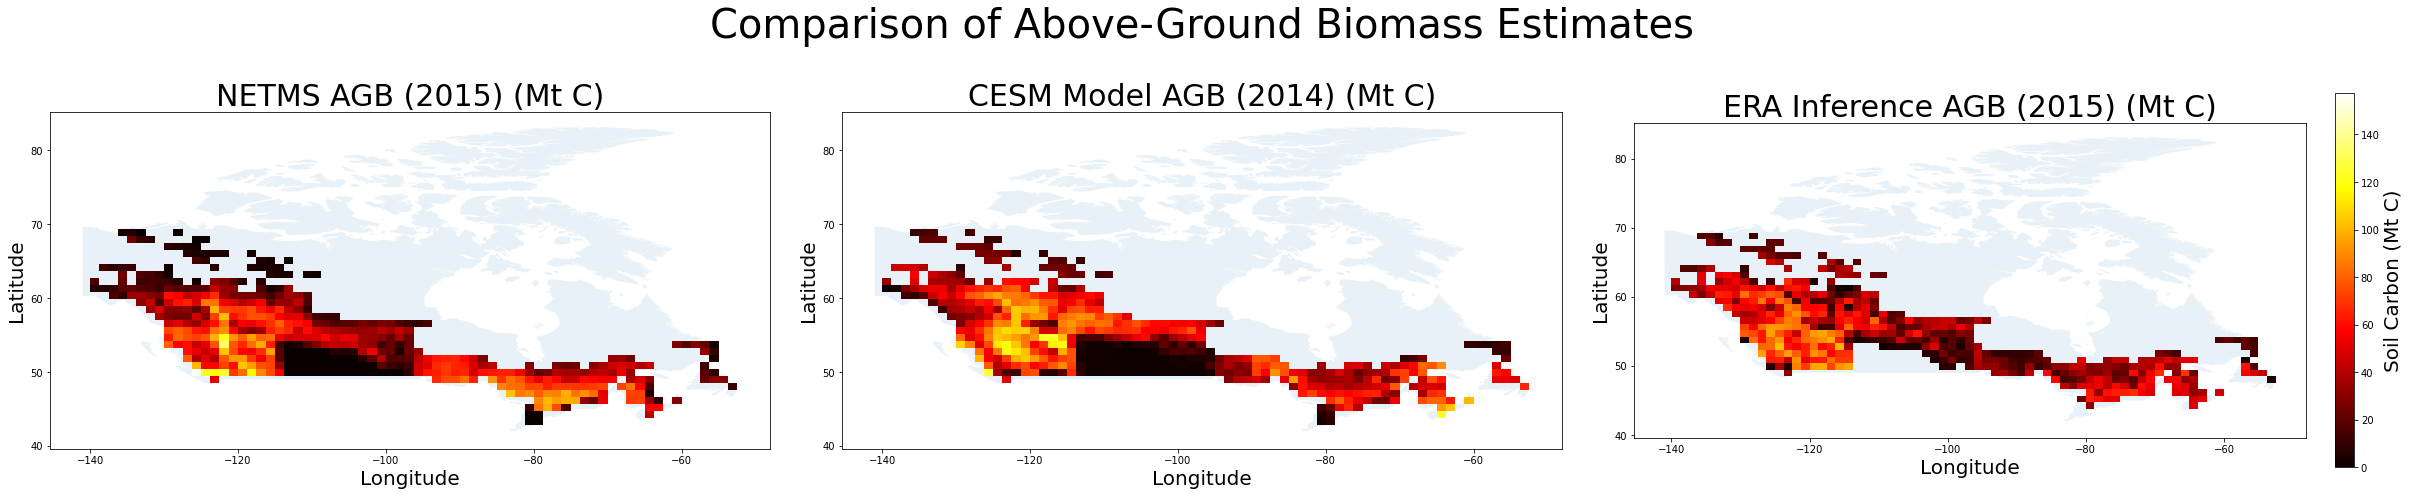

<Figure size 432x288 with 0 Axes>

In [230]:
#AGB FIGURE FOR ESTIMATE COMPARISON
import matplotlib as mpl
f, axes = plt.subplots(figsize=(40, 10),nrows=1,ncols=3)
titles = ["NETMS AGB (2015) (Mt C)",'CESM Model AGB (2014) (Mt C)','ERA Inference AGB (2015) (Mt C)']
data = [nfis_gdf,cesm_gdf,inferred_gdf]
axes = axes.flatten()
norm = mpl.colors.Normalize(0,data[0]['agb'].max(),clip=True)
for ax_index in range(0,len(axes)):
    canada.plot(ax=axes[ax_index],alpha=0.1)
    ax = data[ax_index].plot(ax=axes[ax_index],column='agb',norm=norm,cmap='hot')
    ax.set_xlabel('Longitude',fontsize=20)
    ax.set_ylabel('Latitude',fontsize=20)
    x = mpl.image.AxesImage(ax=axes[ax_index])
    axes[ax_index].title.set_text(titles[ax_index])
    axes[ax_index].title.set_fontsize(30)
m = plt.cm.ScalarMappable(cmap='hot')
m.set_array(data[0]['agb'])
cbar = plt.colorbar(m,fraction=0.026, pad=0.04)
cbar.ax.set_ylabel('Soil Carbon (Mt C)',fontsize=20)
f.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1.1,
                    wspace=0.1,
                    hspace=0)

f.suptitle('Comparison of Above-Ground Biomass Estimates',fontsize=40)
plt.show()
plt.savefig('agb_validation_visualization.png')

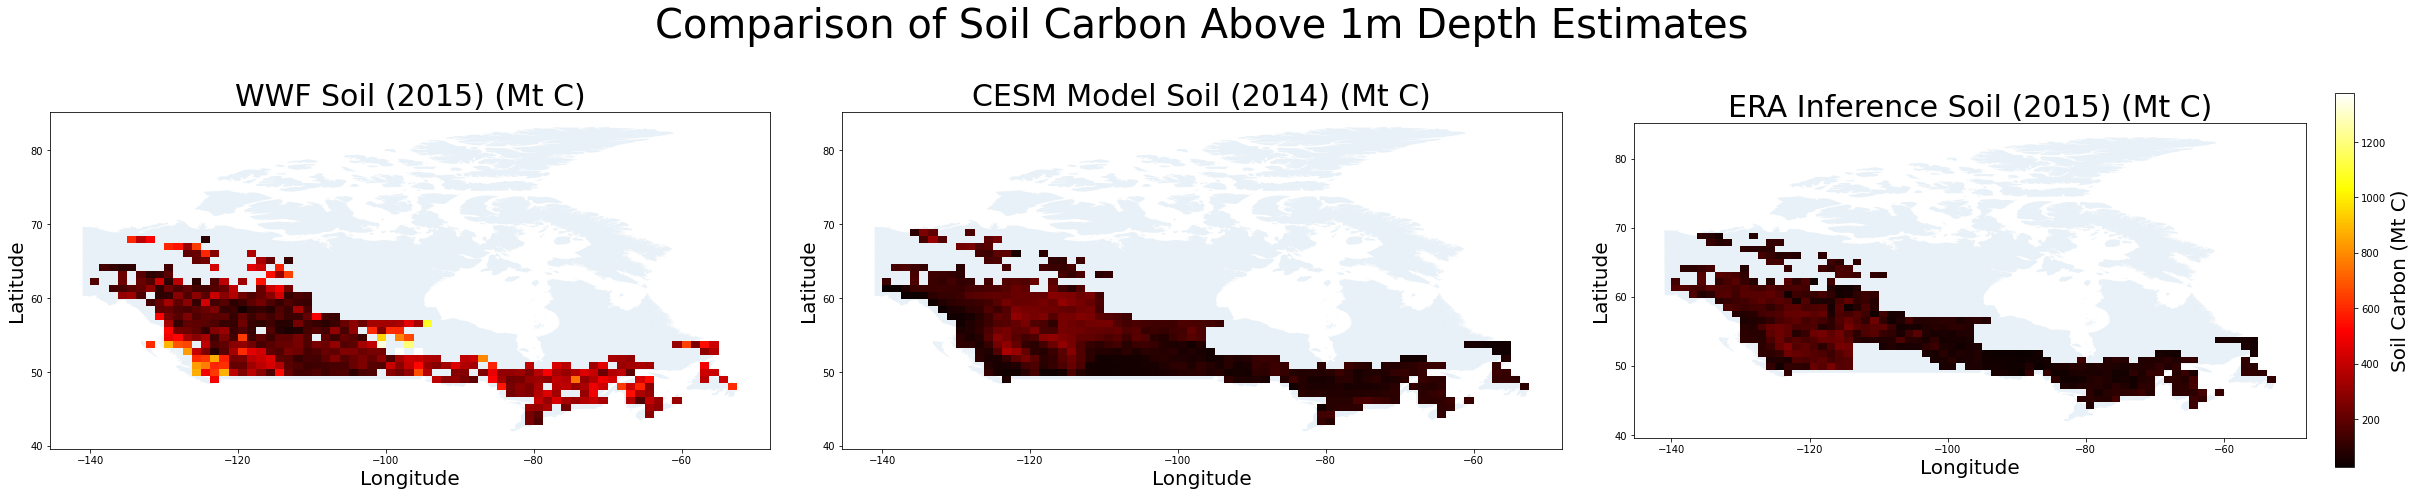

<Figure size 432x288 with 0 Axes>

In [229]:
#SOIL FIGURE FOR ESTIMATE COMPARISON
f, axes = plt.subplots(figsize=(40, 10),nrows=1,ncols=3)
inferred_soil_gdf.fillna(0,inplace=True)
wwf_gdf.fillna(0,inplace=True)
titles = ["WWF Soil (2015) (Mt C)",'CESM Model Soil (2014) (Mt C)','ERA Inference Soil (2015) (Mt C)']
data = [wwf_gdf,cesm_soil_gdf,inferred_soil_gdf]
axes = axes.flatten()
norm = mpl.colors.Normalize(0,data[0]['soil'].max(),clip=True)
for ax_index in range(0,len(axes)):
    canada.plot(ax=axes[ax_index],alpha=0.1)
    ax = data[ax_index].plot(ax=axes[ax_index],column='soil',norm=norm,cmap='hot')
    ax.set_xlabel('Longitude',fontsize=20)
    ax.set_ylabel('Latitude',fontsize=20)
    x = mpl.image.AxesImage(ax=axes[ax_index])
    axes[ax_index].title.set_text(titles[ax_index])
    axes[ax_index].title.set_fontsize(30)
m = plt.cm.ScalarMappable(cmap='hot')
m.set_array(data[0]['soil'])
cbar = plt.colorbar(m,fraction=0.026, pad=0.04)
cbar.ax.set_ylabel('Soil Carbon (Mt C)',fontsize=20)
f.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1.1,
                    wspace=0.1,
                    hspace=0)

f.suptitle('Comparison of Soil Carbon Above 1m Depth Estimates',fontsize=40)
plt.show()
plt.savefig('soil_validation_visualization.png')

In [ ]:
#SUMS OF AGB
print(cesm_data['agb'].sum(),nfis_data['agb'].sum(),inferred_data['agb'].sum())

In [231]:
#SUMS OF SOIL
print(cesm_data['soil'].sum(),soil_pdf['soil'].sum(),inferred_data['soil'].sum())

52935.802667265205 134995.36152895604 41040.11617296131


In [273]:
#RMSE OF AGB COMPARED TO "GROUND TRUTH"
pred_comp_obs = ((nfis_data['agb'].reset_index(drop=True) - cesm_data['agb'].reset_index(drop=True)) ** 2).mean() ** .5
inferred_comp_obs = ((nfis_data['agb'].reset_index(drop=True) - inferred_data['agb'].reset_index(drop=True)) ** 2).mean() ** .5
pred_comp_obs,inferred_comp_obs

(28.513797885490444, 34.089076194557144)

In [272]:
nfis_data.lat = round(nfis_data.lat,6)
xcomp = pd.merge(nfis_data,cesm_data,on=['lat','lon'],how='inner')
((xcomp['agb_y'] - xcomp['agb_x']) ** 2).mean() ** .5

28.513797885490444

In [234]:
pred_comp_obs = ((soil_pdf['soil'].reset_index(drop=True) - cesm_data['soil'].reset_index(drop=True)) ** 2).mean() ** .5
inferred_comp_obs = ((soil_pdf['soil'].reset_index(drop=True) - inferred_data['soil'].reset_index(drop=True)) ** 2).mean() ** .5
comp_obs = ((cesm_data['soil'] - inferred_data['soil']) ** 2).mean() ** .5

pred_comp_obs,inferred_comp_obs,comp_obs

(282.8303722796678, 282.27306860947897, 75.67352031139824)